In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pylab
import random
import copy
from tqdm import tqdm

In [15]:
class node: 
    def __init__(self, wall):
        """
        The general class that will represent the hexagonal nodes at the 2d Numpy array
        """
        self.ni_s = [0, 0, 0, 0, 0, 0] # the nis of the neighbors
        self.wall = wall
        if not wall:
            self.occupied = 0 
        else:
            self.occupied = 1

In [16]:
columns = 300
rows = 300
def initialize():
    """
    A function that builds the 2d Numpy array and fills it with objects from the class node
    """
    vectorized_object = np.vectorize(lambda obj: node(False)) # fill with class node
    config = np.zeros((rows, columns)).astype(object) 
    config[:] = vectorized_object(config[:])
    
    
    vectorized_object_wall = np.vectorize(lambda obj: node(True)) #fill with wall
    
    config[0, :] = vectorized_object_wall(config[0, :])
    config[rows-1, :] = vectorized_object_wall(config[rows-1, :])
    config[:, 0] = vectorized_object_wall(config[:, 0])
    config[:, columns-1] = vectorized_object_wall(config[:, columns-1])
            
     
    return config  
     


def initialize_2():
    """
    This function is similar to the one above but it doesn't add walls. it's used for the periodic boundary
    """
    vectorized_object = np.vectorize(lambda obj: node(False))
    config = np.zeros((rows, columns)).astype(object) 
    config[:] = vectorized_object(config[:])

     
    return config

In [17]:
def observe(config):
    """
    A function that is used to visualize the grid
    """
    
    vectorized_x = np.vectorize(lambda obj: obj.occupied) # get the atribute "occupied" of all cells

    view_grid = vectorized_x(config)
    
    plt.figure(figsize = (10, 8))
    pylab.cla()
    pylab.imshow(view_grid, vmin = 0, vmax = 1, cmap = pylab.cm.binary)

In [18]:
def get_neighbors(coordinates, config):
    """
    A function to get the neighbors of one particle using its coordinates (all hexagonal as explained in the report)
    """
    
    row, column = coordinates
    neighbors = []
    neighbors.append([row, (column+1)%columns]) #right
    neighbors.append([(row-1)%rows, (column+1)%columns]) # top right
    neighbors.append([(row-1)%rows, (column-1)%columns]) #top left
    neighbors.append([row, (column-1)%columns]) #left
    neighbors.append([(row+1)%rows, (column-1)%columns]) #bottom left
    neighbors.append([(row+1)%rows, (column+1)%columns]) # bottom right
    
    return neighbors    



In [29]:

        
def fill_random(N, config, d = False):
    """
    A function to fill N particles in the grid at random locations with random directions
    N: number of particles
    config: the 2d Numpy array
    d: this variable is used to specifiy a direction for all particles. If left to false, particles 
    would have random directions
    """
    samples = random.sample(all_coordinates, N) # take a sample
    for row,column in samples: # place it
        config[row, column].occupied = 1
        
        our_neighbors = get_neighbors([row, column], config)
        while True:
            if not d:
                direction = random.choice([i for i in range(6)]) # make sure that the position is not filled
            else:
                direction = d-1
            n_row, n_col = our_neighbors[direction]
            if not config[n_row,n_col].wall:
                if config[n_row,n_col].occupied == 0:
                    config[n_row,n_col].ni_s[direction]=1
                    break
     
    return config

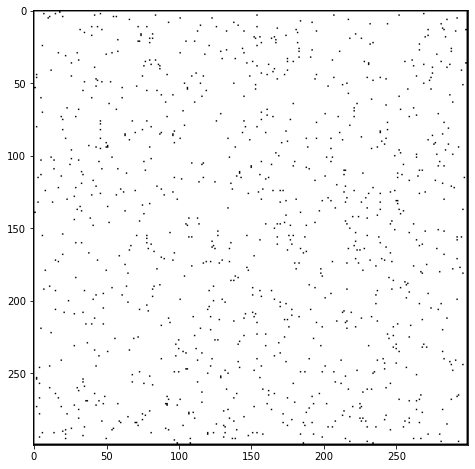

In [20]:
rows = 300
columns = 300
my_grid = initialize()
my_grid = fill_random(1000, my_grid)
observe(my_grid)

In [22]:
def D_i(n, i):
    """
    The head-on collision function
    """
    return n[i%6]*n[(i+3)%6]*(1-n[(i+1)%6])*(1-n[(i+2)%6])*(1-n[(i+4)%6])

def T_i(n, i):
    """
    The three-body collision function
    """
    return n[i]*n[(i+2)%6]*n[(i+4)%6]*(1-n[(i+1)%6])*(1-n[(i+3)%6])*(1-n[(i+5)%6])
def collision_factor(coords, config, i):
    """
    The collision factor Ω
    """
    q = random.choice([0, 1])
    n = config[coords[0], coords[1]].ni_s
    coll = -D_i(n, i)+q*D_i(n, (i-1)%6) + (1-q)*D_i(n, (i+1)%6) - T_i(n, i)+T_i(n, (i+3)%6)
    return coll

In [23]:
def update(config):
    """
    The main function that updates each cell
    """
    next_config = initialize()
    
    for row in range(rows):
        for column in range(columns): # for each cell in the grid
            if not config[row, column].wall: # if it's not a wall

                #get all of its neighbors    
                our_neighbors = get_neighbors([row, column], config)
                
                
                bounce_direc = [] # make this list to store if it's going to bounce off a wall
                
                for i in range(6):# for each neighbor

                    # start by letting the particle that is coming along i (from i+3) get in
                    if config[row, column].ni_s[i] >0:

                        # then update so that the coming particle can enter the cell
                        next_config[row, column].occupied = 1
                        th_row, th_col = our_neighbors[(i+3)%6] # the cell that sent that particle
                        if not next_config[th_row, th_col].wall: 
                            next_config[th_row, th_col].occupied = 0 # update it to 0 since the particle moved already
                        next_config[row, column].ni_s[i] = 0


                    #then for each neghibor, check if something will pop inside them from this cell and change their n_i
                    other_row, other_col = our_neighbors[i]
                    #calculate its value using the equations defined above
                    next_config[other_row,other_col].ni_s[i] = config[row, column].ni_s[i]+\
                                collision_factor([row, column], config, i)
                    
                    # check if any particle is hitting the wall:
                    if next_config[other_row,other_col].wall and next_config[other_row,other_col].ni_s[i]>0:
                        next_config[other_row,other_col].ni_s[i] = 0
                        bounce_direc.append((i+3)%6) #store their bounce off directions
                        
                # if any particles were hiting the wall, send them back:        
                if bounce_direc:
                    next_config[row, column].ni_s[bounce_direc[0]] = 1
            
    return next_config               

In [24]:
def update_periodic(config):
    """
    This function is similar to the one above but it's optimized for the periodic boundary
    it doesn't account for the wall collisions
    """
    next_config = initialize_2()
    for row in range(rows):
        for column in range(columns):   
            our_neighbors = get_neighbors([row, column], config)
            for i in range(6):
                
                other_row, other_col = our_neighbors[i]
                #calculate its value using the FHP equation
                next_config[other_row,other_col].ni_s[i] = config[row, column].ni_s[i]+\
                            collision_factor([row, column], config, i)

                if config[row, column].ni_s[i] >0:

                    # then update so that the coming particle can enter the cell
                    next_config[row, column].occupied = 1
                    th_row, th_col = our_neighbors[i]
                    next_config[th_row, th_col].occupied = 0
                    next_config[row, column].ni_s[i] = 0

            
    return next_config               

In [25]:
def turn_state(config):
    """
    A function to visualize the states
    """
    view_grid = np.copy(config)
    for i in range(len(config)):
        for j in range(len(config)):
            if type(config[i,j]) is not int:
                view_grid[i, j] = config[i,j].occupied
    view_grid = view_grid.astype(int)
    return view_grid




In [159]:
import matplotlib
import matplotlib.animation as animation
from IPython.display import Video
import matplotlib as mpl

def build_animation(states, save_name):
    """
    A function that makes a very nice animation that can be used to debug the code or to 
    enjoy watching the mini city model
    
    Source: https://stackoverflow.com/questions/17212722/matplotlib-imshow-how-to-animate
    """
    
    fps = 20
    nSeconds = len(states)// fps

    # First set up the figure, the axis, and the plot element we want to animate
    fig = plt.figure( figsize=(8,8) )

    a = states[0]



    pylab.cla()
    im = pylab.imshow(a, vmin = 0, vmax = 1, cmap = pylab.cm.binary)


    def animate_func(i):
        if i % fps == 0:
            print( '.', end ='' )

        im.set_array(states[i])
        return [im]

    anim = animation.FuncAnimation(
                                   fig, 
                                   animate_func, 
                                   frames = nSeconds * fps,
                                   interval = 1000 / fps, # in ms
                                   )

    anim.save(save_name, fps=fps, extra_args=['-vcodec', 'libx264'])

    print('Done!')


In [62]:
def fill_random(N, config, d = False):
    """
    A function to fill N particles in the grid at random locations with random directions
    N: number of particles
    config: the 2d Numpy array
    d: this variable is used to specifiy a direction for all particles. If left to false, particles 
    would have random directions
    """
    samples = random.sample(all_coordinates, N) # take a sample
    for row,column in samples: # place it
        config[row, column].occupied = 1
        
        our_neighbors = get_neighbors([row, column], config)
        while True:# make sure that the position is not filled
            if not d:
                direction = random.choice([i for i in range(6)]) 
            else:
                direction = d-1
            n_row, n_col = our_neighbors[direction]
            if not config[n_row,n_col].wall:
                if config[n_row,n_col].occupied == 0:
                    config[n_row,n_col].ni_s[direction]=1
                    break
     
    return config

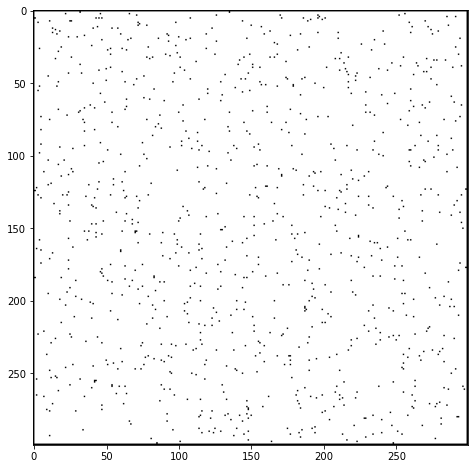

In [164]:
# testing the simulation here: change the number of particles to the test you want:

rows = columns = 300
# getting all the possible coordinates of the 2d grid so that I can take a random sample from them:
i_coords, j_coords = np.meshgrid(range(rows), range(columns), indexing='ij')
coordinate_grid = np.array([i_coords, j_coords])
all_coordinates = []
for i in range(1, rows-1):
    for j in range(1, columns-1):
        all_coordinates.append(list(coordinate_grid[:, i, j]))
        
        

my_grid = initialize()
my_grid = fill_random(1000, my_grid)
observe(my_grid)

In [170]:
states = []
states.append(turn_state(my_grid))
next_grid = update(my_grid)
states.append(turn_state(next_grid))

states.append(turn_state(next_grid))
for i in tqdm(range(200)):
    next_grid = update(next_grid)
    states.append(turn_state(next_grid))

100%|██████████| 200/200 [12:50<00:00,  3.85s/it]


.............................Done!


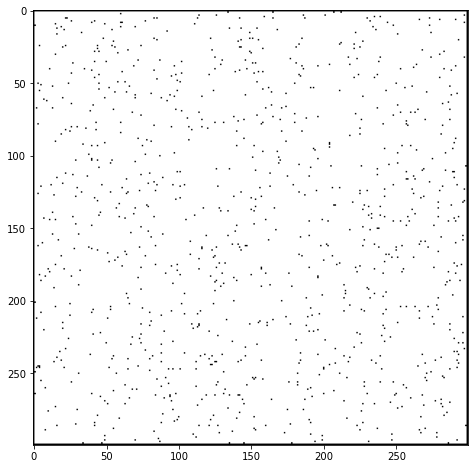

In [171]:
build_animation(states, "try_9.mp4")

In [173]:
from IPython.display import Video
Video("try_9.mp4")